# [공공] 서울시 따릉이 자전거 이용 예측 AI모델

In [45]:
# 모듈
import pandas as pd
import numpy as np
import zipfile

In [46]:
# 데이터 불러오기
!wget 'https://bit.ly/3gLj0Q6'

with zipfile.ZipFile('3gLj0Q6', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-07-23 02:20:21--  https://bit.ly/3gLj0Q6
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E [following]
--2021-07-23 02:20:21--  https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E
Resolving drive.google.com (drive.google.com)... 142.250.141.113, 142.250.141.139, 142.250.141.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l3d8crpecgujmvuguc10kcer20eh8d8n/1627006800000/17946651057176172524/*/1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E?e=download [following]
--2021-07-23 02:20:22--  https://doc-0c-10-docs.googleusercontent.com/docs/secur

In [71]:
# 전처리

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.head())
print('-'*80)
print(train.info())
print('-'*80)
print(train.isnull().sum())
print('-'*80)

print(test.head())
print('-'*80)
print(test.info())
print('-'*80)
print(test.isnull().sum())

# 결측 데이터 제거

train = train.dropna()
test = test.fillna(0)

   id  hour  hour_bef_temperature  ...  hour_bef_pm10  hour_bef_pm2.5  count
0   3    20                  16.3  ...           76.0            33.0   49.0
1   6    13                  20.1  ...           73.0            40.0  159.0
2   7     6                  13.9  ...           32.0            19.0   26.0
3   8    23                   8.1  ...           75.0            64.0   57.0
4   9    18                  29.5  ...           27.0            11.0  431.0

[5 rows x 11 columns]
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour

In [72]:
train_input = train.drop(['count', 'id'], axis=1)
train_target = train['count']

train_input = train_input.to_numpy()
train_target = train_target.to_numpy()

test = test.drop(['id'], axis=1)
test = test.to_numpy()

train_input.shape

(1328, 9)

In [73]:
# Decision Tree를 통한 예측
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# plt.figure(figsize=(10,7))
# plot_tree(dt)
# plt.show()


1.0


[Text(279.0, 317.09999999999997, 'X[0] <= 7.5\nmse = 6867.339\nsamples = 1328\nvalue = 110.805'),
 Text(139.5, 190.26, 'X[0] <= 1.0\nmse = 807.304\nsamples = 411\nvalue = 33.878'),
 Text(69.75, 63.420000000000016, '\n  (...)  \n'),
 Text(209.25, 63.420000000000016, '\n  (...)  \n'),
 Text(418.5, 190.26, 'X[1] <= 18.75\nmse = 5742.36\nsamples = 917\nvalue = 145.284'),
 Text(348.75, 63.420000000000016, '\n  (...)  \n'),
 Text(488.25, 63.420000000000016, '\n  (...)  \n')]

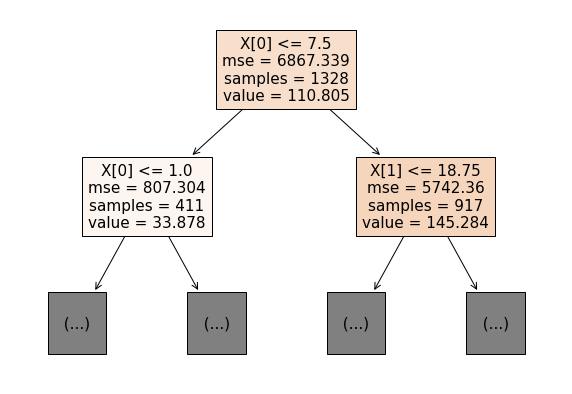

In [50]:
# 깊이 제한후 다시보기
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True)

In [56]:
# 하이퍼파라미터 조절
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))

pred = dt.predict(test)
print(pred.mean())

idx = np.argmax(dt.feature_importances_)

0.7402424668120268
142.04629314692642
0


In [60]:
# 교차검증
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

scores = cross_validate(dt, train_input, train_target)
print(np.mean(scores['test_score']))

splitter = KFold(n_splits=10, shuffle=True)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.6661795576766514
0.679087445300727


In [74]:
# 그리드 서치 활용
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

gs = RandomizedSearchCV(DecisionTreeRegressor(), params,
                        n_iter=100, n_jobs=-1)
gs.fit(train_input, train_target)

print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

{'max_depth': 39, 'min_impurity_decrease': 0.0007469907994883678, 'min_samples_leaf': 9, 'min_samples_split': 24}
0.7033484812739357


In [75]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
rf.fit(train_input, train_target)
print(rf.oob_score_)

from lightgbm import LGBMRegressor


params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

gs = RandomizedSearchCV(LGBMRegressor(), params,
                        n_iter=100, n_jobs=-1)
gs.fit(train_input, train_target)

0.7817270169389954


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           si...
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd566e29690>,

In [76]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

lgb = gs.best_estimator_

pred = lgb.predict(test)
print(pred[:5])

{'max_depth': 26, 'min_impurity_decrease': 0.0008449563707154027, 'min_samples_leaf': 8, 'min_samples_split': 13}
0.7740635332442103
[103.88714764 208.32949219  59.67412191  32.20930961  50.70804004]


In [77]:
# 제출파일 만들기
submission = pd.read_csv('data/submission.csv')

submission['count'] = pred

submission.to_csv('sub.csv', index=False)